In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pathlib import Path
from itertools import product

In [2]:
paths_to_performances = [
    {
        "annotator": "Gonzalo",
        "window": "default",
        "path": "resources/performance_Gonzalo_default.json"
    },
    {
        "annotator": "Gonzalo",
        "window": "abdomen",
        "path": "resources/performance_Gonzalo_abdomen.json"
    },
    {
        "annotator": "Maria Fernanda",
        "window": "default",
        "path": "resources/performance_MariaFernanda_default.json"
    },
    {
        "annotator": "Maria Fernanda",
        "window": "abdomen",
        "path": "resources/performance_MariaFernanda_abdomen.json"
    }
]
paths_to_classes = {
    "Gonzalo": "resources/files_classes_Gonzalo.json",
    "Maria Fernanda": "resources/files_classes_MariaFernanda.json"
}
annotators_colors = {
    'Gonzalo': 'tab:blue',
    'Maria Fernanda': 'tab:orange'
}
labels_to_exclude = [
    ("Gonzalo", "PETCT_15a205ffcc", 1, "Higado"),
    ("Gonzalo", "PETCT_13b40a817b", 1, "derrame")
]
standardized_labels_mapping = {
    "lesiones hepáticas": [
        ("Gonzalo", "PETCT_15a205ffcc", 2, "Lesiones"),
        ("Gonzalo", "PETCT_13b40a817b", 2, "Higado"),
        ("Gonzalo", "PETCT_4c75fa4a5d", 1, "Higado"),
        ("Maria Fernanda", "PETCT_13b40a817b", 1, "lesiones hepaticas"),
        ("Maria Fernanda", "PETCT_4c75fa4a5d", 1, "hígado"),
        ("Maria Fernanda", "PETCT_15a205ffcc", 1, "lesiones hepaticas")
    ],
    "adenopatías": [
        ("Gonzalo", "PETCT_6a3477cd9a", 1, "Adenopatías"),
        ("Maria Fernanda", "PETCT_6a3477cd9a", 1, "adenopatiass mediastinicas y cervicales"),
        ("Maria Fernanda", "PETCT_6a3477cd9a", 2, "adenopatias mesentericas y retroperitoneales"),
        ("Maria Fernanda", "PETCT_6a3477cd9a", 3, "nodulos pulmonares "),
        ("Maria Fernanda", "PETCT_13b40a817b", 2, "adenopatias ")
    ],
    "tumor pulmonar": [
        ("Gonzalo", "PETCT_13b40a817b", 3, "Tumor pulmonar"),
        ("Maria Fernanda", "PETCT_13b40a817b", 3, "masa pulmonar")
    ],
    "pleura": [
        ("Gonzalo", "PETCT_92c5c944a5", 1, "Pleura")
    ]
}

In [3]:
voxel_size_mm = {
    'row': 2.0364201068878174,
    'column': 2.0364201068878174,
    'slice': 3.0
}
measurable_size_mm = 10
smallest_pixels = 5
print(f"{measurable_size_mm / voxel_size_mm['row']} pixels along one X-Y axis sum {measurable_size_mm} mm.")

4.910578110173257 pixels along one X-Y axis sum 10 mm.


In [4]:
# rename keys of classes
annotated_classes = {}
for annotator, path in paths_to_classes.items():
    with open(path, 'r') as file:
        classes_json = json.load(file)
    classes_json = {
        '_'.join(key.split('_')[:2]): value
        for key, value in classes_json.items()
    }
    annotated_classes.update({annotator: classes_json})

In [5]:
# add new columns and concatenate dataframes
performances_df_original = pd.DataFrame()
for item in paths_to_performances:
    with open(item["path"], 'r') as file:
        results = json.load(file)
    performance = pd.DataFrame(results['bboxes'])
    performance['annotator'] = item['annotator']
    performance['window'] = item['window']
    performance['foreground_description'] = performance.apply(
        lambda x: annotated_classes[x['annotator']][x['study']][str(x['foreground_label'])],
        axis=1
    )
    performances_df_original = pd.concat([performances_df_original, performance])
performances_df_original.reset_index(inplace=True, drop=True)

In [6]:
# Exclude non-lesion objects
indices_to_exclude = [
    index
    for index, row in performances_df_original.iterrows()
    if (row['annotator'], row['study'], row['foreground_label'], row['foreground_description']) in labels_to_exclude
]
performances_df = performances_df_original.drop(indices_to_exclude)
# Remove small objects
small_objects_to_exclude = [
    index
    for index, row in performances_df.iterrows()
    if row['annotated_pixels'] < smallest_pixels
]
performances_df = performances_df.drop(small_objects_to_exclude)
print(f"label-excluded objects: {len(indices_to_exclude)}")
print(f"size-excluded objects: {len(small_objects_to_exclude)}")

label-excluded objects: 0
size-excluded objects: 0


In [7]:
# Map original labels to standardized labels
remapping = {
    value: key
    for key, list_ in standardized_labels_mapping.items()
    for value in list_
}
performances_df['standardized_foreground'] = performances_df.apply(
    lambda x: x['foreground_description']
    if (x['annotator'], x['study'], x['foreground_label'], x['foreground_description']) not in remapping.keys()
    else remapping[(x['annotator'], x['study'], x['foreground_label'], x['foreground_description'])],
    axis=1
)

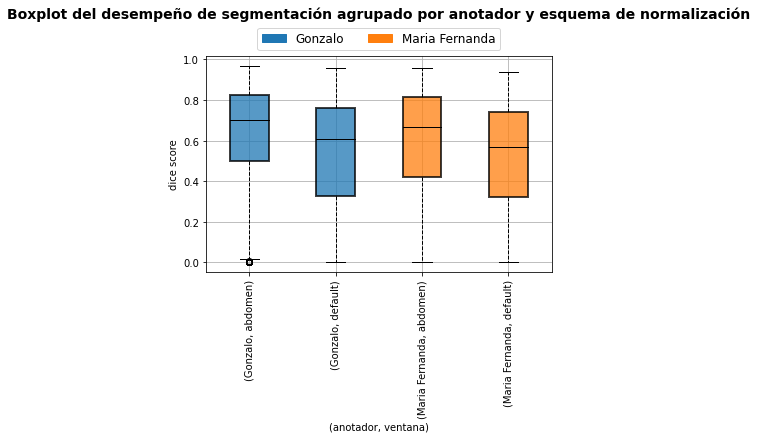

In [8]:
# Performance comparison between annotators and normalization scheme  
boxplot = performances_df.boxplot(
    column='dice_score',
    by=['annotator', 'window'],
    return_type='both',
    patch_artist=True,
    medianprops={'color': 'k', 'linewidth': 1},
    whiskerprops={'linestyle': '--'}
)
annotators_xticks_labels = [
    tick.get_text().split(',')[0].strip()[1:]
    for tick in plt.gca().get_xticklabels()
]
colors = [
    annotators_colors.get(label)
    for label in annotators_xticks_labels
]
for _, (_, row) in boxplot.items():
    for color, box in zip(colors, row['boxes']):
        box.set_facecolor(color)
        box.set_alpha(0.75)
        box.set_linewidth(2)
        box.set_edgecolor('k')
handles = [
    mpatches.Patch(color=color)
    for color in annotators_colors.values()
]
plt.legend(
    handles=handles,
    labels=annotators_colors.keys(),
    loc='upper center',
    ncol=len(annotators_colors),
    bbox_to_anchor=(0.5, 1.16),
    fontsize=12
)
plt.xlabel('(anotador, ventana)')
plt.ylabel('dice score')
plt.suptitle('')
plt.title(
    'Boxplot del desempeño de segmentación agrupado por anotador y esquema de normalización',
    x=0.5,
    y=1.15,
    fontweight='bold',
    fontsize=14
)
plt.xticks(rotation=90)
plt.show()

In [9]:
performances_df.groupby(['annotator', 'window']).describe()['dice_score']

count      mean       std  min       25%       50%  \
annotator      window                                                        
Gonzalo        abdomen  667.0  0.616463  0.276643  0.0  0.500000  0.701987   
               default  661.0  0.530640  0.282431  0.0  0.324675  0.609272   
Maria Fernanda abdomen  876.0  0.575337  0.293393  0.0  0.418964  0.666095   
               default  876.0  0.516975  0.268149  0.0  0.322581  0.567117   

                             75%       max  
annotator      window                       
Gonzalo        abdomen  0.824769  0.967742  
               default  0.761905  0.956204  
Maria Fernanda abdomen  0.815822  0.959436  
               default  0.738623  0.939215

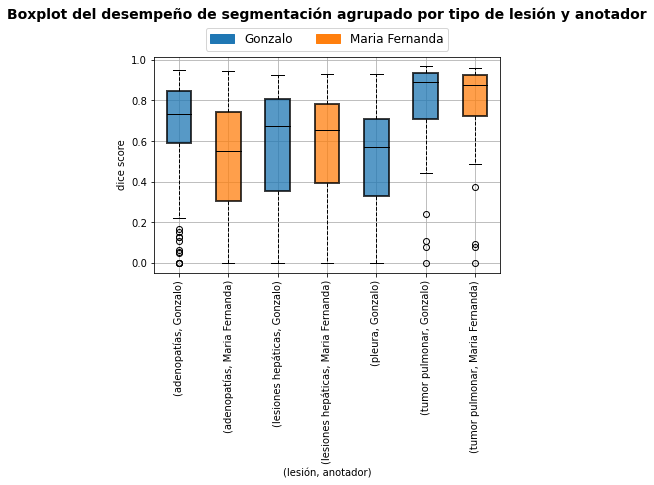

In [10]:
# Boxplot of dice score grouped by annotator and lesion type
boxplot = performances_df.boxplot(
    column='dice_score',
    by=['standardized_foreground', 'annotator'],
    return_type='both',
    patch_artist=True,
    medianprops={'color': 'k', 'linewidth': 1},
    whiskerprops={'linestyle': '--'}
)
annotators_xticks_labels = [
    tick.get_text().split(',')[-1].strip()[:-1]
    for tick in plt.gca().get_xticklabels()
]
colors = [
    annotators_colors.get(label)
    for label in annotators_xticks_labels
]
for _, (_, row) in boxplot.items():
    for color, box in zip(colors, row['boxes']):
        box.set_facecolor(color)
        box.set_alpha(0.75)
        box.set_linewidth(2)
        box.set_edgecolor('k')
handles = [
    mpatches.Patch(color=color)
    for color in annotators_colors.values()
]
plt.legend(
    handles=handles,
    labels=annotators_colors.keys(),
    loc='upper center',
    ncol=len(annotators_colors),
    bbox_to_anchor=(0.5, 1.16),
    fontsize=12
)
plt.xlabel('(lesión, anotador)')
plt.ylabel('dice score')
plt.suptitle('')
plt.title(
    'Boxplot del desempeño de segmentación agrupado por tipo de lesión y anotador',
    x=0.5,
    y=1.15,
    fontweight='bold',
    fontsize=14
)
plt.xticks(rotation=90)
plt.show()

In [11]:
performances_df.groupby(['annotator', 'standardized_foreground']).describe()['dice_score']

count      mean       std  min  \
annotator      standardized_foreground                                   
Gonzalo        adenopatías              262.0  0.686317  0.212068  0.0   
               lesiones hepáticas       507.0  0.560580  0.308074  0.0   
               pleura                   503.0  0.505276  0.264135  0.0   
               tumor pulmonar            56.0  0.781258  0.237355  0.0   
Maria Fernanda adenopatías              750.0  0.508196  0.281129  0.0   
               lesiones hepáticas       944.0  0.561308  0.278228  0.0   
               tumor pulmonar            58.0  0.790389  0.220688  0.0   

                                             25%       50%       75%       max  
annotator      standardized_foreground                                          
Gonzalo        adenopatías              0.588235  0.733333  0.844067  0.951768  
               lesiones hepáticas       0.354248  0.675497  0.809267  0.925823  
               pleura                   0.329932  0.568627  0.707825  0.928571  
               tumor pulmonar           0.707148  0.890609  0.934456  0.967742  
Maria Fernanda adenopatías              0.302153  0.550510  0.740487  0.946136  
               lesiones hepáticas       0.390978  0.652632  0.782918  0.928382  
               tumor pulmonar           0.723676  0.877764  0.926036  0.959436

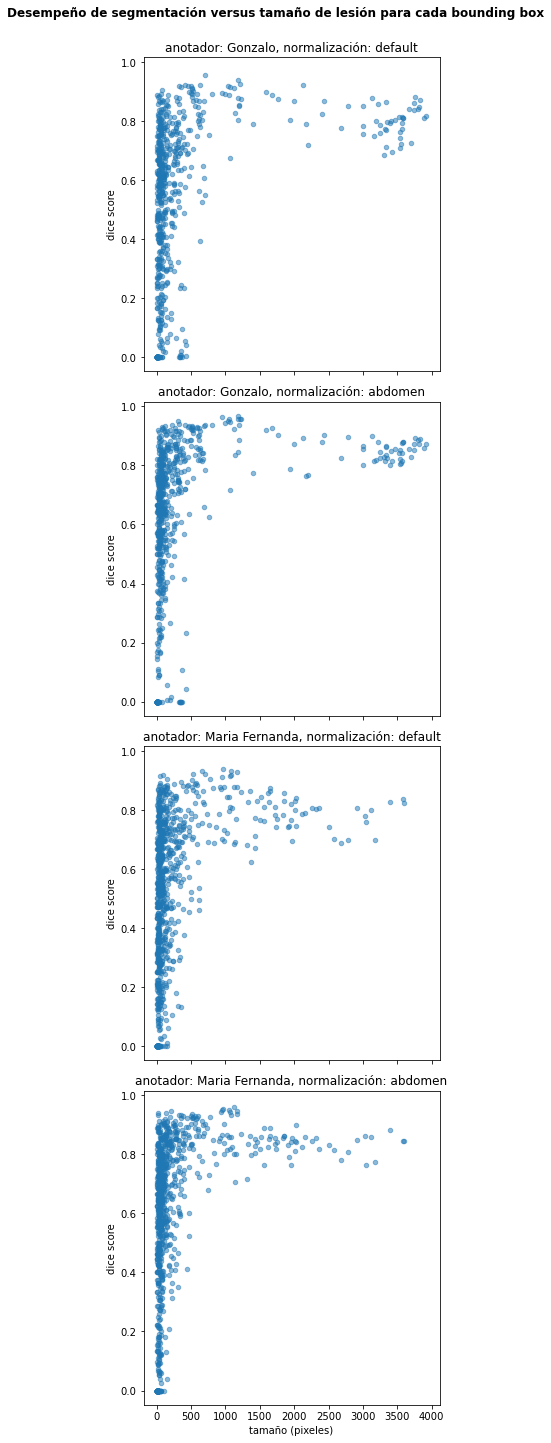

In [12]:
unique_annotators = performances_df['annotator'].unique()
unique_windows = performances_df['window'].unique()
combs = list(product(unique_annotators, unique_windows))
_, ax = plt.subplots(len(combs), 1, figsize=(5, 20), sharex=True, sharey=True)
plt.suptitle(
    "Desempeño de segmentación versus tamaño de lesión para cada bounding box",
    fontweight='bold',
    y=1.0
)
for idx, (annotator, window) in enumerate(combs):
    performances_df[
        (performances_df['annotator'] == annotator) &
        (performances_df['window'] == window)
    ].plot.scatter(
        x='annotated_pixels',
        y='dice_score',
        ax=ax[idx],
        alpha=0.5
    )
    ax[idx].set_title(f"anotador: {annotator}, normalización: {window}")
    ax[idx].set_xlabel('tamaño (pixeles)')
    ax[idx].set_ylabel('dice score')
plt.tight_layout()
plt.show()

In [13]:
# Paths to json files with performance for different bbox scales
paths_to_performances_bboxes = [
    {
        "annotator": "Gonzalo",
        "window": "abdomen",
        "bbox_scale": 0.5,
        "path": "resources/performance_Gonzalo_abdomen_window_scale_0_5.json"
    },
    {
        "annotator": "Gonzalo",
        "window": "abdomen",
        "bbox_scale": 0.75,
        "path": "resources/performance_Gonzalo_abdomen_window_scale_0_75.json"
    },
    {
        "annotator": "Gonzalo",
        "window": "abdomen",
        "bbox_scale": 1.0,
        "path": "resources/performance_Gonzalo_abdomen_window_scale_1_0.json"
    },
    {
        "annotator": "Gonzalo",
        "window": "abdomen",
        "bbox_scale":1.25,
        "path": "resources/performance_Gonzalo_abdomen_window_scale_1_25.json"
    },
    {
        "annotator": "Gonzalo",
        "window": "abdomen",
        "bbox_scale": 1.5,
        "path": "resources/performance_Gonzalo_abdomen_window_scale_1_5.json"
    },
    {
        "annotator": "Gonzalo",
        "window": "abdomen",
        "bbox_scale": 1.75,
        "path": "resources/performance_Gonzalo_abdomen_window_scale_1_75.json"
    },
    {
        "annotator": "Gonzalo",
        "window": "abdomen",
        "bbox_scale": 2.0,
        "path": "resources/performance_Gonzalo_abdomen_window_scale_2_0.json"
    },
    {
        "annotator": "Maria Fernanda",
        "window": "abdomen",
        "bbox_scale": 0.5,
        "path": "resources/performance_MariaFernanda_abdomen_window_scale_0_5.json"
    },
    {
        "annotator": "Maria Fernanda",
        "window": "abdomen",
        "bbox_scale": 0.75,
        "path": "resources/performance_MariaFernanda_abdomen_window_scale_0_75.json"
    },
    {
        "annotator": "Maria Fernanda",
        "window": "abdomen",
        "bbox_scale": 1.0,
        "path": "resources/performance_MariaFernanda_abdomen_window_scale_1_0.json"
    },
    {
        "annotator": "Maria Fernanda",
        "window": "abdomen",
        "bbox_scale": 1.25,
        "path": "resources/performance_MariaFernanda_abdomen_window_scale_1_25.json"
    },
    {
        "annotator": "Maria Fernanda",
        "window": "abdomen",
        "bbox_scale": 1.5,
        "path": "resources/performance_MariaFernanda_abdomen_window_scale_1_5.json"
    },
    {
        "annotator": "Maria Fernanda",
        "window": "abdomen",
        "bbox_scale": 1.75,
        "path": "resources/performance_MariaFernanda_abdomen_window_scale_1_75.json"
    },
    {
        "annotator": "Maria Fernanda",
        "window": "abdomen",
        "bbox_scale": 2.0,
        "path": "resources/performance_MariaFernanda_abdomen_window_scale_2_0.json"
    }
]

In [14]:
# add new columns and concatenate dataframes
performances_df_bboxes_original = pd.DataFrame()
for item in paths_to_performances_bboxes:
    with open(item["path"], 'r') as file:
        results = json.load(file)
    performance = pd.DataFrame(results['bboxes'])
    performance['annotator'] = item['annotator']
    performance['window'] = item['window']
    performance['bbox_scale'] = item["bbox_scale"]
    performance['foreground_description'] = performance.apply(
        lambda x: annotated_classes[x['annotator']][x['study']][str(x['foreground_label'])],
        axis=1
    )
    performances_df_bboxes_original = pd.concat([performances_df_bboxes_original, performance])
performances_df_bboxes_original.reset_index(inplace=True, drop=True)

In [15]:
# Exclude non-lesion objects
indices_to_exclude = [
    index
    for index, row in performances_df_bboxes_original.iterrows()
    if (row['annotator'], row['study'], row['foreground_label'], row['foreground_description']) in labels_to_exclude
]
performances_df_bboxes = performances_df_bboxes_original.drop(indices_to_exclude)
# Remove small objects
small_objects_to_exclude = [
    index
    for index, row in performances_df_bboxes.iterrows()
    if row['annotated_pixels'] < smallest_pixels
]
performances_df_bboxes = performances_df_bboxes.drop(small_objects_to_exclude)
print(f"label-excluded objects: {len(indices_to_exclude)}")
print(f"size-excluded objects: {len(small_objects_to_exclude)}")

label-excluded objects: 0
size-excluded objects: 0


In [16]:
# Map original labels to standardized labels
remapping = {
    value: key
    for key, list_ in standardized_labels_mapping.items()
    for value in list_
}
performances_df_bboxes['standardized_foreground'] = performances_df_bboxes.apply(
    lambda x: x['foreground_description']
    if (x['annotator'], x['study'], x['foreground_label'], x['foreground_description']) not in remapping.keys()
    else remapping[(x['annotator'], x['study'], x['foreground_label'], x['foreground_description'])],
    axis=1
)

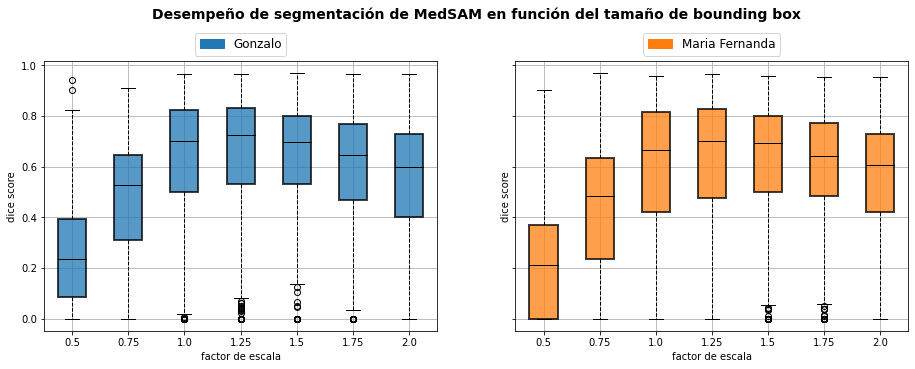

In [17]:
# MedSAM performance as a function of the bounding box scale
_, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,5))
for idx, annotator in enumerate(performances_df_bboxes['annotator'].unique()):
    boxplot = performances_df_bboxes[performances_df_bboxes['annotator'] == annotator].boxplot(
        column='dice_score',
        by='bbox_scale',
        return_type='both',
        patch_artist=True,
        medianprops={'color':'k', 'linewidth': 1},
        whiskerprops={'linestyle': '--'},
        ax=ax[idx]
    )
    for _, (_, row) in boxplot.items():
        for box in row['boxes']:
            box.set_facecolor(annotators_colors[annotator])
            box.set_alpha(0.75)
            box.set_linewidth(2)
            box.set_edgecolor('k')
    handles = [mpatches.Patch(color=annotators_colors[annotator])]
    labels = [annotator]
    ax[idx].legend(
        handles=handles,
        labels=labels,
        loc='upper center',
        bbox_to_anchor=(0.5, 1.125),
        fontsize=12
    )
    ax[idx].set_xlabel('factor de escala')
    ax[idx].set_ylabel('dice score')
    ax[idx].set_title('')
plt.suptitle(
    'Desempeño de segmentación de MedSAM en función del tamaño de bounding box',
    x=0.5,
    y=1.05,
    fontweight='bold',
    fontsize=14
)
#plt.savefig('MedSAM_performance_Gatidis_HCUCH_annotations_bbox_scales.png', bbox_inches='tight')
plt.show()